## This notebook does the following 
* **Retrieves and prints basic data about a movie (title entered by user) from the web (OMDB database)**
* **If a poster of the movie could be found, it downloads the file and saves at a user-specified location**
* **Finally, stores the movie data in a local SQLite database**

In [2]:
import urllib.request, urllib.parse, urllib.error
import json
import pandas as pd 

### Gets the secret API key (you have to get one from OMDB website and use that, 1000 daily limit) from a JSON file, stored in the same folder

with open('APIkeys.json') as f:
    keys = json.load(f)

omdbapi = keys['OMDBapi']

In [3]:
# including the personal token in all the request to the API
omdbapi= 'cba04cc6'
serviceurl = 'http://www.omdbapi.com/?'
apikey = '&apikey='+omdbapi


### Function for printing a JSON dataset

In [4]:
def print_json(json_data):
    list_keys=['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 'Writer', 
               'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Ratings', 
               'Metascore', 'imdbRating', 'imdbVotes', 'imdbID']
    print("-"*50)
    for k in list_keys:
        if k in list(json_data.keys()):
            print(f"{k}: {json_data[k]}")
    print("-"*50)


### Function to download a poster of the movie based on the information from the jason dataset
**Saves the downloaded poster in a local directory called 'Posters'**

In [5]:
def save_poster(json_data):
    import os
    title = json_data['Title']
    poster_url = json_data['Poster']
    # Splits the poster url by '.' and picks up the last string as file extension
    poster_file_extension=poster_url.split('.')[-1]
    # Reads the image file from web
    poster_data = urllib.request.urlopen(poster_url).read()
    
    #cuidado con el path de Posters.
    
    savelocation=os.getcwd()+'/Posters/'
    print(savelocation)
    # Creates new directory if the directory does not exist. Otherwise, just use the existing path.
    if not os.path.isdir(savelocation):
        os.mkdir(savelocation)
    
    filename=savelocation+str(title)+'.'+poster_file_extension
    f=open(filename,'wb')
    f.write(poster_data)
    f.close()


### Function to create/update the local movie database with the data retreived from the web
**Saves the movie data (Title, Year, Runtime, Country, Metascore, and IMDB rating) into a local SQLite database called 'movieinfo.sqlite'** 

In [6]:
import sqlite3 # base de datos server-less ligera


def save_in_database(json_data):
    
    filename = input("Please enter a name for the database (extension not needed, it will be added automatically): ")
    filename = filename+'.sqlite'
    
    conn = sqlite3.connect(str(filename))
    cur=conn.cursor() # el cursor ejecuta sentencias SQL
    
    title = json_data['Title']
    # Goes through the json dataset and extracts information if it is available
    if json_data['Year']!='N/A':
        year = int(json_data['Year'])
    if json_data['Runtime']!='N/A':
        runtime = int(json_data['Runtime'].split()[0])
    if json_data['Country']!='N/A':
        country = json_data['Country']
    if json_data['Metascore']!='N/A':
        metascore = float(json_data['Metascore'])
    else:
        metascore=-1
    if json_data['imdbRating']!='N/A':
        imdb_rating = float(json_data['imdbRating'])
    else:
        imdb_rating=-1
    
    # SQL commands
    cur.execute('''CREATE TABLE IF NOT EXISTS MovieInfo 
    (Title TEXT, Year INTEGER, Runtime INTEGER, Country TEXT, Metascore REAL, IMDBRating REAL)''')
    
    cur.execute('SELECT Title FROM MovieInfo WHERE Title = ? ', (title,))
    row = cur.fetchone()
    
    if row is None:
        cur.execute('''INSERT INTO MovieInfo (Title, Year, Runtime, Country, Metascore, IMDBRating)
                VALUES (?,?,?,?,?,?)''', (title,year,runtime,country,metascore,imdb_rating))
    else:
        print("Record already found. No update made.")
    
    # Commits the change and close the connection to the database
    conn.commit()
    conn.close()


### Function to print contents of  the local database

In [7]:

def print_database(database):
    
    #import sqlite3
    conn = sqlite3.connect(str(database))
    cur=conn.cursor()
    
    for row in cur.execute('SELECT * FROM MovieInfo'):
        print(row)
    conn.close()


### Function to save the database content in an Excel file

In [8]:

def save_in_excel(filename, database):
    
    if filename.split('.')[-1]!='xls' and filename.split('.')[-1]!='xlsx':
        print ("Filename does not have correct extension. Please try again")
        return None
    
    #import pandas as pd
    #import sqlite3
    
    #df=pd.DataFrame(columns=['Title','Year', 'Runtime', 'Country', 'Metascore', 'IMDB_Rating'])
    
    conn = sqlite3.connect(str(database))
    #cur=conn.cursor()
    
    df=pd.read_sql_query("SELECT * FROM MovieInfo", conn)
    conn.close()
    
    df.to_excel(filename,sheet_name='Movie Info')


### Function to search for information about a movie

In [9]:

def search_movie(title):
    if len(title) < 1 or title=='quit': 
        print("Goodbye now...")
        return None

    try:
        url = serviceurl + urllib.parse.urlencode({'t': title})+apikey
        print(f'Retrieving the data of "{title}" now... ')
        uh = urllib.request.urlopen(url)
        data = uh.read()
        json_data=json.loads(data)
        
        if json_data['Response']=='True':
            print_json(json_data)
            
            # Asks user whether to download the poster of the movie
            if json_data['Poster']!='N/A':
                poster_yes_no=input ('Poster of this movie can be downloaded. Enter "yes" or "no": ').lower()
                if poster_yes_no=='yes':
                    save_poster(json_data)
            # Asks user whether to save the movie information in a local database
            save_database_yes_no=input ('Save the movie info in a local database? Enter "yes" or "no": ').lower()
            if save_database_yes_no=='yes':
                save_in_database(json_data)
        else:
            print("Error encountered: ",json_data['Error'])
    
    except urllib.error.URLError as e:
        print(f"ERROR: {e.reason}")


#### Search for 'Titanic'

In [12]:
title = input('\nEnter the name of a movie (enter \'quit\' or hit ENTER to quit): ')
if len(title) < 1 or title=='quit': 
    print("Goodbye now...")
else:
    search_movie(title)

Retrieving the data of "One flew over the cuckoo's nest" now... 
--------------------------------------------------
Title: One Flew Over the Cuckoo's Nest
Year: 1975
Rated: R
Released: 19 Nov 1975
Runtime: 133 min
Genre: Drama
Director: Milos Forman
Writer: Lawrence Hauben (screenplay), Bo Goldman (screenplay), Ken Kesey (based on the novel by), Dale Wasserman (the play version: "One Flew Over the Cuckoo's Nest" by)
Actors: Michael Berryman, Peter Brocco, Dean R. Brooks, Alonzo Brown
Plot: A criminal pleads insanity and is admitted to a mental institution, where he rebels against the oppressive nurse and rallies up the scared patients.
Language: English
Country: USA
Awards: Won 5 Oscars. Another 30 wins & 15 nominations.
Ratings: [{'Source': 'Internet Movie Database', 'Value': '8.7/10'}, {'Source': 'Rotten Tomatoes', 'Value': '93%'}, {'Source': 'Metacritic', 'Value': '83/100'}]
Metascore: 83
imdbRating: 8.7
imdbVotes: 900,953
imdbID: tt0073486
------------------------------------------

#### Show the downloaded poster of 'Titanic'

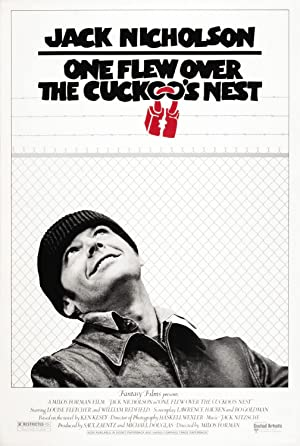

In [20]:
from IPython.display import Image
Image("Posters/One Flew Over the Cuckoo's Nest.jpg")

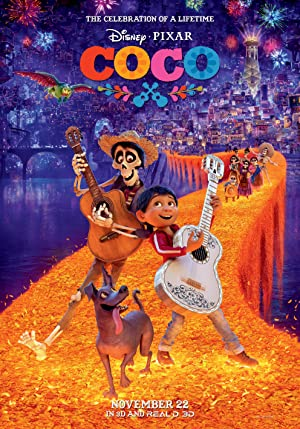

In [21]:
from IPython.display import Image
Image("Posters/Coco.jpg")

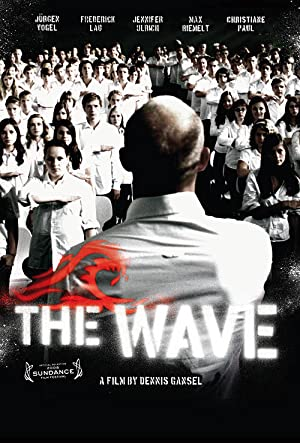

In [25]:
from IPython.display import Image
Image("Posters/The wave.jpg")

#### Print the content of the local database, only single entry so far

In [28]:
print_database("OpenMovieDB.sqlite")

('Titanic', 1997, 194, 'USA, Mexico, Australia, Canada', 75.0, 7.8)
("One Flew Over the Cuckoo's Nest", 1975, 133, 'USA', 83.0, 8.7)
('To Kill a Mockingbird', 1962, 129, 'USA', 88.0, 8.2)
('Jumanji', 1995, 104, 'USA', 39.0, 7.0)
('Coco', 2017, 105, 'USA', 81.0, 8.4)
('The Wave', 2008, 107, 'Germany, France', -1.0, 7.6)


#### Search for 'Jumanji'

In [23]:

title = input('\nEnter the name of a movie (enter \'quit\' or hit ENTER to quit): ')
if len(title) < 1 or title=='quit': 
    print("Goodbye now...")
else:
    search_movie(title)


Retrieving the data of " Wave" now... 
--------------------------------------------------
Title: The Wave
Year: 2008
Rated: Not Rated
Released: 27 May 2011
Runtime: 107 min
Genre: Drama, Thriller
Director: Dennis Gansel
Writer: Ron Jones (short story and original protocols), Johnny Dawkins (screenplay "The Wave"), Ron Birnbach (screenplay "The Wave"), Dennis Gansel, Peter Thorwarth
Actors: Jürgen Vogel, Frederick Lau, Max Riemelt, Jennifer Ulrich
Plot: A high school teacher's experiment to demonstrate to his students what life is like under a dictatorship spins horribly out of control when he forms a social unit with a life of its own.
Language: German
Country: Germany, France
Awards: 9 wins & 8 nominations.
Ratings: [{'Source': 'Internet Movie Database', 'Value': '7.6/10'}, {'Source': 'Rotten Tomatoes', 'Value': '67%'}]
Metascore: N/A
imdbRating: 7.6
imdbVotes: 100,964
imdbID: tt1063669
--------------------------------------------------
c:\Users\pilar\Edition_Jun2020\Repositorios_GitH

#### Search for "To kill a mockingbird"

In [18]:
title = input('\nEnter the name of a movie (enter \'quit\' or hit ENTER to quit): ')
if len(title) < 1 or title=='quit': 
    print("Goodbye now...")
else:
    search_movie(title)


Retrieving the data of "Coco" now... 
--------------------------------------------------
Title: Coco
Year: 2017
Rated: PG
Released: 22 Nov 2017
Runtime: 105 min
Genre: Animation, Adventure, Family, Fantasy, Music, Mystery
Director: Lee Unkrich, Adrian Molina(co-director)
Writer: Lee Unkrich (original story by), Jason Katz (original story by), Matthew Aldrich (original story by), Adrian Molina (original story by), Adrian Molina (screenplay by), Matthew Aldrich (screenplay by)
Actors: Anthony Gonzalez, Gael García Bernal, Benjamin Bratt, Alanna Ubach
Plot: Aspiring musician Miguel, confronted with his family's ancestral ban on music, enters the Land of the Dead to find his great-great-grandfather, a legendary singer.
Language: English, Spanish
Country: USA
Awards: Won 2 Oscars. Another 108 wins & 37 nominations.
Ratings: [{'Source': 'Internet Movie Database', 'Value': '8.4/10'}, {'Source': 'Rotten Tomatoes', 'Value': '97%'}, {'Source': 'Metacritic', 'Value': '81/100'}]
Metascore: 81
imdb

#### Save the database content into an Excel file

In [27]:
save_in_excel("OpenMovie.xlsx","OpenMovieDB.sqlite")

In [29]:
df = pd.read_excel('OpenMovie.xlsx')

In [30]:
df

,Unnamed: 0,Title,Year,Runtime,Country,Metascore,IMDBRating
0,0,Titanic,1997,194,"USA, Mexico, Australia, Canada",75,7.8
1,1,One Flew Over the Cuckoo's Nest,1975,133,USA,83,8.7
2,2,To Kill a Mockingbird,1962,129,USA,88,8.2
3,3,Jumanji,1995,104,USA,39,7.0
4,4,Coco,2017,105,USA,81,8.4
5,5,The Wave,2008,107,"Germany, France",-1,7.6
